In [14]:
import os
import json
import requests
import jiwer
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
%load_ext dotenv
%dotenv

In [3]:
id_catalog = os.environ["ID_CATALOG_YANDEX"]
api_key = os.environ["API_KEY_YANDEX"]

In [4]:
# Функция подключения к API YandexGPT 3 Pro с возвратом сгенерированного развернутого описания
def pred_history(message):
    prompt = {
        "modelUri": f"gpt://{id_catalog}/yandexgpt/latest",  # YandexGPT 3 Pro
        "completionOptions": {"stream": False, "temperature": 0.6, "maxTokens": "2000"},
        "messages": [
            {
                "role": "system",
                "text": "Ты русский писатель детских рассказов. Всегда возвращаешь текст только на русском.",
            },
            {
                "role": "user",
                "text": message,
            },
        ],
    }

    url = "https://llm.api.cloud.yandex.net/foundationModels/v1/completion"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Api-Key {api_key}",
    }

    response = requests.post(url, headers=headers, json=prompt)

    result = json.loads(response.text)

    return result["result"]["alternatives"][0]["message"]["text"]

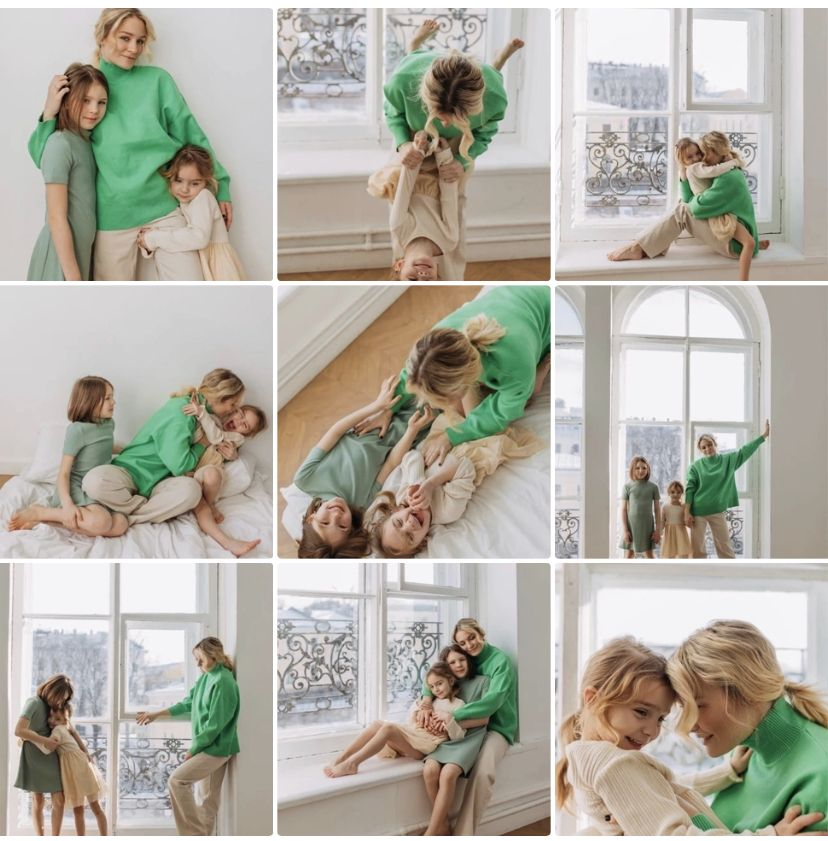

In [5]:
# Пример фотографий для генерации развернутого описания
image = Image.open("datasets/photosession.jpg")

image

In [6]:
# Входные данные от клиента (синтетический пример по фотографиям выше)
img_input = [
    "arafed image of a woman and two girls posing for a picture",  # закрашенное изображение женщины и двух девочек, позирующих для фотосессии
    "a woman bending over holds a child in her arms in a room",  # женщина наклонившись держит на руках ребенка в комнате
    "there is a woman and a child sitting on a window sill",  # на подоконнике сидят женщина и ребенок
    "there are two children that are laying on a bed together",  # есть двое детей, которые лежат вместе на кровати
    "there are three women laying on a bed with a child",  # на кровати лежат три женщины с ребенком
    "there are three women and a child standing in front of a window",  # перед окном стоят три женщины и ребенок
    "there are two women standing next to each other near a window",  # у окна стоят рядом друг с другом две женщины
    "there are two pictures of a woman and a child sitting on a window sill",  # там есть две фотографии женщины и ребенка, сидящих на подоконнике
    "arafed woman and child smiling at each other while standing in front of a window",  # женщина в черном и ребенок улыбаются друг другу, стоя перед окном
]

text_input = "Фотосессия в белой комнате фотостудии у большого окна мамы в ярком зеленом свиторе с дочерьми младшая Саша старшая Катя"

setup_input = "В тексте не использовать слова фотография, изображение"

In [7]:
# Финальный запрос для генерации развернутого описания
message = f"""
        Напиши развернутое описание происходящего на {len(img_input)} фотографиях объединив в сюжет.
        Описания фотографий: {img_input}.
        Дополнительное описание к фотографий: {text_input}.
        Дополнительные требования: {setup_input}.
"""

In [8]:
result = pred_history(message)

result

'В уютной фотостудии, где стены были окрашены в белый цвет, а большое окно выходило на оживлённую улицу, проходила фотосессия. У окна стояли мама и её дочки — Саша и Катя.\n\nМама, одетая в яркий зелёный свитер, обнимала своих девочек. Она улыбалась и смотрела на них с любовью. Саша, младшая дочка, стояла рядом с мамой и держала её за руку. А старшая дочка, Катя, стояла чуть поодаль и делала вид, что ей не нравится вся эта суета. Но на самом деле она тоже была счастлива.\n\nФотограф попросил маму взять Сашу на руки, чтобы сделать ещё один снимок. Мама с радостью подхватила дочку и подняла её вверх. В этот момент Саша засмеялась от счастья, а мама поцеловала её в щёку.\n\nПосле фотосессии все трое решили немного отдохнуть. Они сели на широкий подоконник и стали смотреть на людей, которые проходили мимо. Мама рассказывала девочкам о том, как она сама маленькой девочкой любила сидеть у окна и наблюдать за прохожими. И вот теперь она сидит здесь со своими дочками и вспоминает своё детство.

In [1]:
answer = """
    В уютной фотостудии, где стены были окрашены в белый цвет, а большое окно выходило на оживлённую улицу, 
    проходила фотосессия. У окна стояли мама и её дочки — Саша и Катя.

    Мама, одетая в яркий зелёный свитер, обнимала своих девочек. Она улыбалась и смотрела на них с любовью. 
    Саша, младшая дочка, стояла рядом с мамой и держала её за руку. А старшая дочка, Катя, стояла чуть поодаль 
    и делала вид, что ей не нравится вся эта суета. Но на самом деле она тоже была счастлива.

    Фотограф попросил маму взять Сашу на руки, чтобы сделать ещё один снимок. Мама с радостью подхватила дочку 
    и подняла её вверх. В этот момент Саша засмеялась от счастья, а мама поцеловала её в щёку.
    
    После фотосессии все трое решили немного отдохнуть. Они сели на широкий подоконник и стали смотреть на людей, 
    которые проходили мимо. Мама рассказывала девочкам о том, как она сама маленькой девочкой любила сидеть у окна 
    и наблюдать за прохожими. И вот теперь она сидит здесь со своими дочками и вспоминает своё детство.
    
    Пока они сидели у окна, к ним подошла женщина, которая работала в фотостудии. Она принесла им чай и печенье. 
    Все вместе они пили чай и разговаривали. А потом женщины решили прилечь на мягкий диван, который стоял в углу 
    комнаты. Вскоре к ним присоединилась и Саша. Она устроилась между мамой и Катей и закрыла глаза.
    
    Так они и лежали все вместе, наслаждаясь покоем и тишиной. Им было хорошо и уютно. Казалось, что время остановилось, 
    и они могут лежать так вечно.
    
    Но вскоре их покой был нарушен. В комнату вошли ещё две женщины. Это были подруги мамы. Они пришли поздравить её с 
    очередной фотосессией и принесли с собой торт. Все были рады встрече. Они смеялись и шутили, вспоминая прошлые дни. 
    А маленькая Саша сидела у мамы на коленях и слушала их разговоры. Ей было интересно всё, о чём говорили взрослые.
    
    В конце концов, все четверо женщин и маленькая девочка встали перед окном. Они смотрели на город, который лежал внизу, 
    и думали о своём. О чём они думали, никто не знал. Может быть, они мечтали о будущем, а может быть, просто наслаждались 
    настоящим. Но одно было ясно: они были счастливы вместе.
"""

In [5]:
# Функция расчета метрики METEOR
def metric_meteor(predicted_texts, reference_texts):
    metrics = []

    for i in range(len(predicted_texts)):
        reference_tokens = word_tokenize(reference_texts[i])
        predicted_tokens = word_tokenize(predicted_texts[i])

        meteor = meteor_score([reference_tokens], predicted_tokens)
        metrics.append(meteor)

    return metrics / len(metrics)

In [8]:
# Функция расчета косинусного сходства между текстами на основе угла между векторами
def cos_similarity(predicted_texts, reference_texts):
    metrics = []

    for i in range(len(predicted_texts)):
        tfidf_vectorizer = TfidfVectorizer()
        tfidf_matrix = tfidf_vectorizer.fit_transform(
            [predicted_texts[i], reference_texts[i]]
        )

        cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])
        metrics.append(cosine_sim)

    return metrics / len(metrics)

In [9]:
# Функция расчета Жаккара сходства между двумя множествами слов в текстах
def jaccard_similarity(predicted_texts, reference_texts):
    metrics = []

    for i in range(len(predicted_texts)):
        set1 = set(predicted_texts[i].lower().split())
        set2 = set(reference_texts[i].lower().split())

        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))

        jaccard_sim = intersection / union if union != 0 else 0

        metrics.append(jaccard_sim)

    return metrics / len(metrics)

In [10]:
# Функция расчета расстояния Левенштейна измеряющая минимальное количество операций (вставка, удаление, замена символов)
def levenshtein_distance(predicted_texts, reference_texts):
    metrics = []

    for i in range(len(predicted_texts)):
        if len(predicted_texts[i]) < len(reference_texts[i]):
            return levenshtein_distance(reference_texts[i], predicted_texts[i])

        if len(reference_texts[i]) == 0:
            return len(predicted_texts[i])

        previous_row = range(len(reference_texts[i]) + 1)

        for i, c1 in enumerate(predicted_texts[i]):
            current_row = [i + 1]

            for j, c2 in enumerate(reference_texts[i]):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))

            previous_row = current_row
        metrics.append(previous_row[-1])

    return metrics / len(metrics)

In [12]:
# Функция расчета Евклидово расстояния измеряющее расстояние между двумя точками в многомерном пространстве
def euclidean_distance(predicted_texts, reference_texts):
    metrics = []

    for i in range(len(predicted_texts)):
        vectorizer = CountVectorizer()
        vectorizer.fit([predicted_texts[i], reference_texts[i]])
        vectorized_text1 = vectorizer.transform([predicted_texts[i]])
        vectorized_text2 = vectorizer.transform([reference_texts[i]])

        euclidean_distance = euclidean_distances(vectorized_text1, vectorized_text2)
        metrics.append(euclidean_distance[0][0])

    return metrics / len(metrics)

In [16]:
# Функция расчета частоты ошибок в словах (WER)
def metric_wer(predicted_texts, reference_texts):
    metrics = []

    for i in range(len(predicted_texts)):
        wer = jiwer.wer(reference_texts[i], predicted_texts[i])
        metrics.append(wer)

    return metrics / len(metrics)